In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
import cv2
import os
import pandas as pd
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.image import load_img
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="1"



Using TensorFlow backend.


In [2]:
filePath = "img_align_celeba/"
inputData = os.listdir(filePath)
img_shape = (64, 64, 3)

def datagen(batchSize,filesList):
    while(True):
        files = np.random.choice(filesList,batchSize,replace=False)
        X_train = []
        for file in files:
            image = cv2.imread(filePath + "/" + file)
#             print(np.array(image).min(),np.array(image).max())
#             print(np.array(image).shape)
#             plt.imshow(image)
            image = cv2.resize(image,(64,64),interpolation = cv2.INTER_CUBIC)
            image = image / 255.0
            X_train.append(image)
        X_train = np.array(X_train)
        yield X_train
        
def discDatagen(batchSize,filesList):
    while(True):
        files = np.random.choice(filesList,batchSize,replace=False)
        X_train, y = [],[]
        for file in files:
            image = cv2.imread(filePath + "/" + file)
#             print(np.array(image).min(),np.array(image).max())
#             print(np.array(image).shape)
#             plt.imshow(image)
            image = cv2.resize(image,(64,64),interpolation = cv2.INTER_CUBIC)
            blurImage = cv2.blur(image,ksize=(8,8))
#             fig = plt.figure(figsize=(6,3))
#             ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
#             ax.imshow(image[:,:,::-1])
#             ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
#             ax.imshow(blurImage[:,:,::-1])
            image = image / 255.0
            blurImage = blurImage / 255.0
            X_train.append(image)
            y.append(0) # for real image
            X_train.append(blurImage)
            y.append(1) # for blurr/fake image
        X_train = np.array(X_train)
        Y_train = to_categorical(y,num_classes=2)
        yield X_train, Y_train
        
randomDim = 100
batchSize = 10
epochs = 1

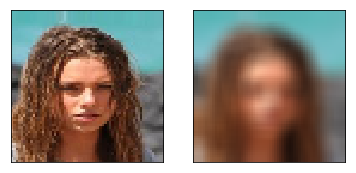

In [3]:
discDatagenObj = discDatagen(batchSize,inputData)
for i in range(1):
    x,y = next(discDatagenObj)
#     print(x.shape)
#     print(y)
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.imshow(x[0][:,:,::-1])
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.imshow(x[0+1][:,:,::-1])
#     print(x[0][:,:,::-1].shape)

In [4]:

np.random.seed(1000)


# Optimizer

In [ ]:
adam = Adam(lr=0.0002, beta_1=0.5)

# Generator

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GeneratorInput (Dense)       (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 256)       0         
__________

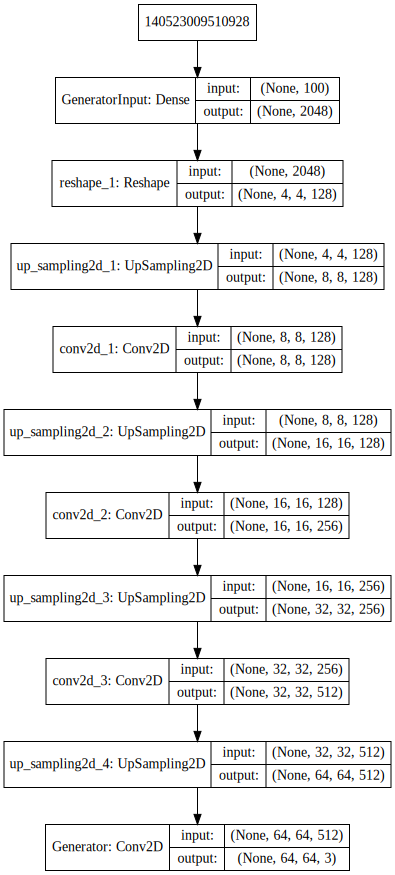

In [ ]:
generator = Sequential(name='Generator')
generator.add(Dense(128*4*4, input_dim=randomDim,name='GeneratorInput', activation='relu'))
# generator.add(LeakyReLU(0.2))
generator.add(Reshape((4, 4, 128)))

generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
# generator.add(LeakyReLU(0.2))

generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))


generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
# generator.add(LeakyReLU(0.2))

generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(3, kernel_size=(3, 3), padding='same', activation='sigmoid',name='Generator'))
generator.compile(loss='binary_crossentropy', optimizer='sgd', metrics = ['accuracy'])
generator.summary()
display(SVG(model_to_dot(generator,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))



# Discriminator

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       18560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       295168    
__________

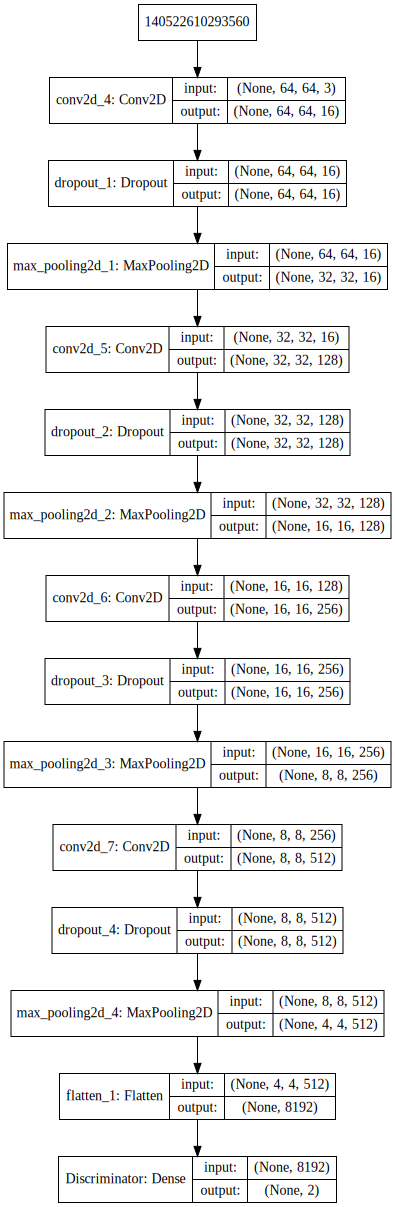

In [ ]:
# Discriminator
discriminator = Sequential(name='Discriminator')

discriminator.add(Conv2D(input_shape=(64,64,3),filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Flatten())
discriminator.add(Dense(2, activation='softmax',name='Discriminator'))
discriminator.compile(loss='categorical_crossentropy', optimizer='sgd', metrics = ['accuracy'])
discriminator.summary()
display(SVG(model_to_dot(discriminator,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))





# Combined = GAN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
Generator (Sequential)       (None, 64, 64, 3)         1843587   
_________________________________________________________________
Discriminator (Sequential)   (None, 2)                 1510722   
Total params: 3,354,309
Trainable params: 1,843,587
Non-trainable params: 1,510,722
_________________________________________________________________


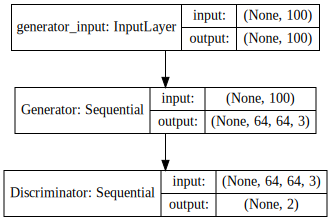

In [ ]:

discriminator.trainable = False
ganInput = Input(shape=(randomDim,),name='generator_input')
x = generator(ganInput)
# print(x.shape)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput, name='GAN')
# gan.layers[1].name = "Generator_Network"
# gan.layers[2].name = "Discriminator_Network"
gan.compile(loss='binary_crossentropy', optimizer='sgd', metrics = ['accuracy'])
gan.summary()
display(SVG(model_to_dot(gan,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))


In [ ]:

tensorboard = TensorBoard(
  log_dir='log/run17',
  histogram_freq=0,
  batch_size=batchSize,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(gan)



# helper functions

In [ ]:
dLosses = []
gLosses = []

def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_cnn_64x64_longrun/dcgan_%d_loss_epoch.png' % epoch)

def plotGeneratedImages(epoch, examples=100, dim=(1, 1), figsize=(2, 2)):
    randomDim = 100
#     examples=1
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
#     print(generatedImages.shape)
#     generatedImages = generatedImages*255.0 + 255.0
#     print(generatedImages.min(),generatedImages.max())
    fig = plt.figure(figsize=(30,3))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(generatedImages[i][:,:,::-1])
    fol = 'images/gan_cnn_64x64_longrun/faces/'
    if not os.path.exists(fol):
        os.makedirs(fol)
    plt.savefig(fol+'random_{:06d}.png'.format(epoch))
    
    
def saveModels(epoch):
    fol = 'models/gan_cnn_64x64_longrun/'
    if not os.path.exists(fol):
        os.makedirs(fol)
    generator.save(fol+'dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save(fol+'dcgan_discriminator_epoch_%d.h5' % epoch)

# Pre-Train the discriminator 

/home/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.6906 - acc: 0.5000 - val_loss: 0.6897 - val_acc: 0.5000
Epoch 2/200
1/1 [==============================] - 0s 77ms/step - loss: 0.6862 - acc: 0.5000 - val_loss: 0.6891 - val_acc: 0.5039
Epoch 3/200
1/1 [==============================] - 0s 80ms/step - loss: 0.6842 - acc: 0.5000 - val_loss: 0.6881 - val_acc: 0.5000
Epoch 4/200
1/1 [==============================] - 0s 77ms/step - loss: 0.6827 - acc: 0.5117 - val_loss: 0.6876 - val_acc: 0.5000
Epoch 5/200
1/1 [==============================] - 0s 83ms/step - loss: 0.6824 - acc: 0.5195 - val_loss: 0.6868 - val_acc: 0.5117
Epoch 6/200
1/1 [==============================] - 0s 87ms/step - loss: 0.6823 - acc: 0.5039 - val_loss: 0.6860 - val_acc: 0.5156
Epoch 7/200
1/1 [==============================] - 0s 80ms/step - loss: 0.6800 - acc: 0.5273 - val_loss: 0.6851 - val_acc: 0.5469
Epoch 8/200
1/1 [==============================] - 0s 79ms/step - loss: 0.6801 - acc: 0.5117

Epoch 64/200
1/1 [==============================] - 0s 110ms/step - loss: 0.5801 - acc: 0.8555 - val_loss: 0.6303 - val_acc: 0.9102
Epoch 65/200
1/1 [==============================] - 0s 126ms/step - loss: 0.5728 - acc: 0.8711 - val_loss: 0.6276 - val_acc: 0.9297
Epoch 66/200
1/1 [==============================] - 0s 131ms/step - loss: 0.5739 - acc: 0.8945 - val_loss: 0.6252 - val_acc: 0.9531
Epoch 67/200
1/1 [==============================] - 0s 101ms/step - loss: 0.5721 - acc: 0.8047 - val_loss: 0.6268 - val_acc: 0.8750
Epoch 68/200
1/1 [==============================] - 0s 153ms/step - loss: 0.5662 - acc: 0.9102 - val_loss: 0.6195 - val_acc: 0.9609
Epoch 69/200
1/1 [==============================] - 0s 114ms/step - loss: 0.5614 - acc: 0.7852 - val_loss: 0.6231 - val_acc: 0.8477
Epoch 70/200
1/1 [==============================] - 0s 128ms/step - loss: 0.5580 - acc: 0.9023 - val_loss: 0.6155 - val_acc: 0.9648
Epoch 71/200
1/1 [==============================] - 0s 131ms/step - loss: 0.

Epoch 126/200
1/1 [==============================] - 0s 142ms/step - loss: 0.5919 - acc: 0.6094 - val_loss: 0.5103 - val_acc: 0.9922
Epoch 127/200
1/1 [==============================] - 0s 138ms/step - loss: 0.4314 - acc: 0.8086 - val_loss: 0.5565 - val_acc: 0.8359
Epoch 128/200
1/1 [==============================] - 0s 126ms/step - loss: 0.4262 - acc: 0.9531 - val_loss: 0.4937 - val_acc: 0.9961
Epoch 129/200
1/1 [==============================] - 0s 130ms/step - loss: 0.4126 - acc: 0.8594 - val_loss: 0.5766 - val_acc: 0.6836
Epoch 130/200
1/1 [==============================] - 0s 128ms/step - loss: 0.4374 - acc: 0.8867 - val_loss: 0.4834 - val_acc: 0.9922
Epoch 131/200
1/1 [==============================] - 0s 130ms/step - loss: 0.4395 - acc: 0.6602 - val_loss: 0.6231 - val_acc: 0.5469
Epoch 132/200
1/1 [==============================] - 0s 129ms/step - loss: 0.5554 - acc: 0.6406 - val_loss: 0.4873 - val_acc: 1.0000
Epoch 133/200
1/1 [==============================] - 0s 133ms/step - 

Epoch 188/200
1/1 [==============================] - 0s 150ms/step - loss: 0.2101 - acc: 0.9961 - val_loss: 0.3906 - val_acc: 0.9531
Epoch 189/200
1/1 [==============================] - 0s 130ms/step - loss: 0.2020 - acc: 0.9922 - val_loss: 0.3320 - val_acc: 0.9883
Epoch 190/200
1/1 [==============================] - 0s 126ms/step - loss: 0.1888 - acc: 1.0000 - val_loss: 0.3871 - val_acc: 0.9219
Epoch 191/200
1/1 [==============================] - 0s 125ms/step - loss: 0.1877 - acc: 0.9922 - val_loss: 0.3303 - val_acc: 0.9648
Epoch 192/200
1/1 [==============================] - 0s 121ms/step - loss: 0.1785 - acc: 0.9922 - val_loss: 0.3816 - val_acc: 0.8906
Epoch 193/200
1/1 [==============================] - 0s 128ms/step - loss: 0.1844 - acc: 0.9922 - val_loss: 0.2970 - val_acc: 0.9961
Epoch 194/200
1/1 [==============================] - 0s 127ms/step - loss: 0.2022 - acc: 0.9883 - val_loss: 0.5066 - val_acc: 0.6953
Epoch 195/200
1/1 [==============================] - 0s 128ms/step - 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdd0422358>,
      dtype=object)

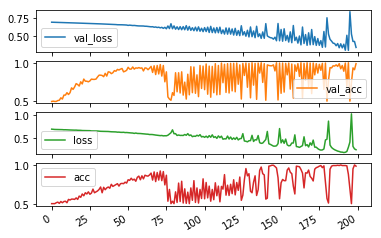

In [ ]:
discDatagenObj_tr = discDatagen(batchSize=128,filesList=inputData)
discDatagenObj_vl = discDatagen(batchSize=128,filesList=inputData)
hist = discriminator.fit_generator(discDatagenObj_tr,epochs=200,steps_per_epoch=1,validation_data=discDatagenObj_vl,validation_steps=1,verbose=1)

df = pd.DataFrame(hist.history)
df.plot(subplots=True)

# Training Code

In [ ]:
def train(epochs=1, batchSize=128, number_of_steps = 10):
    
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('steps per epoch:',number_of_steps)
    datagenObj = datagen(batchSize,inputData)
    counter = 0
    for e in tqdm(range(1, epochs+1)):
        for step in range(number_of_steps):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            realImages = next(datagenObj)
            generatedImages = generator.predict(noise)
#             print(generatedImages.shape)
#             print(imageBatch.shape)
            X = np.concatenate([realImages, generatedImages])
            yDis = np.ones(2*batchSize)
            yDis[:batchSize] = 0 # real images 0 fake 1# normal training
            yDis = to_categorical(yDis,num_classes=2)
            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
#             print(dloss)
            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.zeros(batchSize) # pose generated images as real # imposter
            yGen = to_categorical(yGen,num_classes=2)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
#             print(gloss)
#             counter+=1
            
            tensorboard.on_epoch_end(e, {"D_acc":dloss[1],"D_loss":dloss[0],"G_acc":gloss[1],"G_loss":gloss[0]})
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 1000 == 0:
            plotGeneratedImages(e)
            saveModels(e)
    tensorboard.on_train_end(None)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    print("")
    train(100000, 128, 1)



  0%|          | 0/100000 [00:00<?, ?it/s]


Epochs: 100000
Batch size: 128
steps per epoch: 1


 20%|█▉        | 19999/100000 [1:58:59<7:56:00,  2.80it/s]/home/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
 24%|██▍       | 24078/100000 [2:23:19<7:31:54,  2.80it/s]

In [ ]:
examples=100
dim=(1, 1)
figsize=(2, 2)
noise = np.random.normal(0, 1, size=[examples, randomDim])
generatedImages = generator.predict(noise)
#     generatedImages = generatedImages*255.0 + 255.0
#     print(generatedImages.min(),generatedImages.max())
fig = plt.figure(figsize=(60,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(generatedImages[i][:,:,::-1])